# Functions from `ImagePipeline.ipynb`

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import math

def grayscale(img):
    """NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')
    Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = draw_lines(img, lines, [255, 0, 0], 2);
    
    return line_img, lines

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    Draw an array of line segments on a blank image
    """
    line_img=np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8);
    if lines is None:
        return line_img
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return line_img

def slope_thresholding(img,lines):
    """
    This function isolates somewhat vertical line segments.
    Then, it divides raw line segments into left and right lane.
    
    Input: 
    img= Color image from dashcam
    lines= Set of line segments which denote parts of lane lines
    """
    lane_raw=[];
    
    #Check if no raw lines were detected
    if lines is None:
        raw_lane_img= draw_lines(img, lines, [0, 255, 0], 2);
        return raw_lane_img, [], []
    
    #Ignore segments which are somewhat horizontal
    for pts in lines:
        for x1,y1,x2,y2 in pts:
            m=(y2-y1)/(x2-x1)
            if m>.25 or m<-.25:
                lane_raw.append(pts)
    
    #Separate left and right lanes
    left_lane_raw=[];
    right_lane_raw=[];
    for pts in lane_raw:
        for x1,y1,x2,y2 in pts:
            slope=((y2-y1)/(x2-x1));
            if slope<0:
                left_lane_raw.append(pts)
            else:
                right_lane_raw.append(pts)
                
    left_raw_img = draw_lines(img, left_lane_raw, [0, 255, 0], 2)
    right_raw_img = draw_lines(img, right_lane_raw, [0, 0, 255], 2)
    
    
    raw_lane_img = weighted_img(left_raw_img,right_raw_img,1,1,0)
    return raw_lane_img, left_lane_raw, right_lane_raw
    
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def draw_lanes(img, left_lane_raw, right_lane_raw, pastLane):
    """
    This function plots left and right lane lines on dashcam image

    The raw lane lines are aggregated into single line segments denoting lane lines
    """
    
    #Find Top and Bottom x values of the lane
    #y_top=lines[0][0][1]
    #y_bottom=lines[0][0][1]
    #for pts in lines:
    #    for x1,y1,x2,y2 in pts:
    #        if y_top>y1:
    #            y_top=y1
    #        if y_bottom<y1:
    #            y_bottom=y1
    #        if y_top>y2:
    #            y_top=y2
    #        if y_bottom<y2:
    #            y_bottom=y2
    y_bottom=img.shape[0]
    y_top=.6*img.shape[0]

    presentlane=[];
    #Average raw Lane Lines to get single equation for left and right lanes
    presentlane.append(avg_line(left_lane_raw)) #line in form x,y,dx,dy
    presentlane.append(avg_line(right_lane_raw))
    
    #Average Lane lines according to their past position
    lane=avg_lanes_time(presentlane,pastLane)
    
    #Calculate final lane end points
    finallane=[]
    if not(len(lane[0])==0):
        left_x,left_y,left_dx,left_dy=lane[0]
        t1=(y_top-left_y)/left_dy
        t2=(y_bottom-left_y)/left_dy
        left_lane=np.array([(left_x+t1*left_dx),y_top,(left_x+t2*left_dx),y_bottom]);
        left_lane=left_lane.astype(int)
        finallane.append([left_lane])
    
    if not(len(lane[1])==0):
        right_x,right_y,right_dx,right_dy=lane[1]
        t1=(y_top-right_y)/right_dy
        t2=(y_bottom-right_y)/right_dy
        right_lane=np.array([(right_x+t1*right_dx),y_top,(right_x+t2*right_dx),y_bottom]);
        right_lane=right_lane.astype(int)
        finallane.append([right_lane])
    
    lane_img=draw_lines(img, finallane);    
    return lane_img, lane

def avg_line(lines):
    if (len(lines)==0):
        return []
    
    avg_pt=np.array([0,0])
    avg_dirn=np.array([0,0])
    for pts in lines:
        for x1,y1,x2,y2 in pts:
            dirn=np.array([x2-x1,y2-y1])
            avg_dirn=avg_dirn+(dirn/np.linalg.norm(dirn))
            avg_pt=avg_pt+[(x1+x2)/2.0,(y1+y2)/2.0]
    avg_pt=avg_pt/len(lines)
    avg_dirn=avg_dirn/len(lines)
    x=avg_pt[0]
    y=avg_pt[1]
    dx=avg_dirn[0]
    dy=avg_dirn[1]
    
    #print (x,y,dx,dy)
    return [x,y,dx,dy]

def avg_lanes_time(present,past,w=.5):
    avg_lane=[];
    #First compare left lanes
    if len(present[0])==0 and len(past[0])==0:
        avg_lane.append([])
    elif len(present[0])==0:
        avg_lane.append(past[0])
    elif len(past[0])==0:
        avg_lane.append(present[0])
    else:
        arr=w*np.array(present[0])+(1-w)*np.array(past[0])
        avg_lane.append(arr.tolist())
        
    
    
    #Then compare right lanes
    if len(present[1])==0 and len(past[1])==0:
        avg_lane.append([])
    elif len(present[1])==0:
        avg_lane.append(past[1])
    elif len(past[1])==0:
        avg_lane.append(present[1])
    else:
        arr=w*np.array(present[1])+(1-w)*np.array(past[1])
        avg_lane.append(arr.tolist())
    
    return avg_lane

def detailImg(Img1, Img2, Img3, Img4, Img5, Img6, Img7, Img8, Img9):

    #Combile all images and show results
    ht=Img1.shape[0]
    wd=Img1.shape[1]
    DetailImg=np.zeros((3*ht, 3*wd, 3), dtype=np.uint8);
    DetailImg[:ht,:wd]=Img1;
    DetailImg[:ht,wd:2*wd]=cv2.merge((Img2,Img2,Img2));
    DetailImg[:ht,2*wd:3*wd]=cv2.merge((Img3,Img3,Img3));
    DetailImg[ht:2*ht,:wd]=cv2.merge((Img4,Img4,Img4));
    DetailImg[ht:2*ht,wd:2*wd]=cv2.merge((Img5,Img5,Img5));
    DetailImg[ht:2*ht,2*wd:3*wd]=Img6;
    DetailImg[2*ht:3*ht,:wd]=Img7;
    DetailImg[2*ht:3*ht,wd:2*wd]=Img8;
    DetailImg[2*ht:3*ht,2*wd:3*wd]=Img9;

    #Add titles for each step
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 1.5
    color = (255,255,255)
    thickness = 4
    linetype = cv2.LINE_AA
    w_off=10
    h_off=80
    cv2.putText(DetailImg, "1.Input", (w_off,h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "2.Grayscaling", (wd+w_off,h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "3.Blurring", (2*wd+w_off,h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "4.Edge Detection", (w_off,ht+h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "5.Region Masking", (wd+w_off,ht+h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "6.Hough Transform", (2*wd+w_off,ht+h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "7.Slope Thresholding", (w_off,2*ht+h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "8.Line averaging", (wd+w_off,2*ht+h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "9.Final Visualization", (2*wd+w_off,2*ht+h_off),font,scale,color,thickness,linetype)


    #Create grid seperators
    cv2.line(DetailImg, (wd, 0), (wd, 3*ht), [255,255,255], 2)
    cv2.line(DetailImg, (2*wd, 0), (2*wd, 3*ht), [255,255,255], 2)
    cv2.line(DetailImg, (0, ht), (3*wd, ht), [255,255,255], 2)
    cv2.line(DetailImg, (0, 2*ht), (3*wd, 2*ht), [255,255,255], 2)
    
    return DetailImg

def pipeline(Img, hyper, pastLaneLines=[[],[]]):
    #STEP 1- INPUT
    Img1=Img

    #STEP 2- Grayscaling
    Img2=grayscale(Img1)

    #STEP 3- Blurring
    Img3=gaussian_blur(Img2, hyper['blur_kernel_size'])

    #STEP 4- Edge detection
    Img4=canny(Img3, hyper['canny_low'], hyper['canny_high'])

    #STEP 5- Region Masking
    Low_Lf=[.05*Img1.shape[1],Img1.shape[0]]
    Up_Lf=[.45*Img1.shape[1],.6*Img1.shape[0]]
    Up_Rt=[.55*Img1.shape[1],.6*Img1.shape[0]]
    Low_Rt=[.95*Img1.shape[1],Img1.shape[0]]
    poly=np.array([[Low_Lf,Up_Lf,Up_Rt,Low_Rt]], dtype=np.int32)
    Img5=region_of_interest(Img4, poly)

    #STEP 6- Hough Transform
    #Detecting line segments from edge pixels and creating blank image with lane lines
    (Img6,lines)=hough_lines(Img5, hyper['hough_rho'], hyper['hough_theta'], hyper['hough_threshold'], 
                             hyper['hough_min_line_len'], hyper['hough_max_line_gap'])

    #STEP 7- Slope Thresholding
    (Img7,left_raw,right_raw)=slope_thresholding(Img6,lines)

    #STEP 8- Averaging Raw lines
    Img8, LaneLines=draw_lanes(Img7,left_raw,right_raw,pastLaneLines)
    
    #STEP 9- Final Visualization
    #Superimposing lanes on original image
    Img9=weighted_img(Img8, Img1)
    
    #Generate Detail Image
    Img10=detailImg(Img1, Img2, Img3, Img4, Img5, Img6, Img7, Img8, Img9)
    return Img9, Img10, LaneLines
    

Hyperparam={'blur_kernel_size':5,
            'canny_low':50,
            'canny_high':150,
            'hough_rho':2,
            'hough_theta':np.pi/90,
            'hough_threshold':40,
            'hough_min_line_len':30,
            'hough_max_line_gap':20,};

# Testing environment for camera pipeline

To test and debug my realtime camera pipeline, I have printed out an image of road and pinned it on my study table. The setup is shown in the image below.

In [2]:
# REFERENCE: https://towardsdatascience.com/video-streaming-in-the-jupyter-notebook-635bc5809e85

from ipywebrtc import CameraStream, ImageRecorder
back_camera = CameraStream.facing_environment(audio=False)
image_recorder = ImageRecorder(stream=back_camera)
image_recorder

ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'video': {'facingMode': 'environment'},…

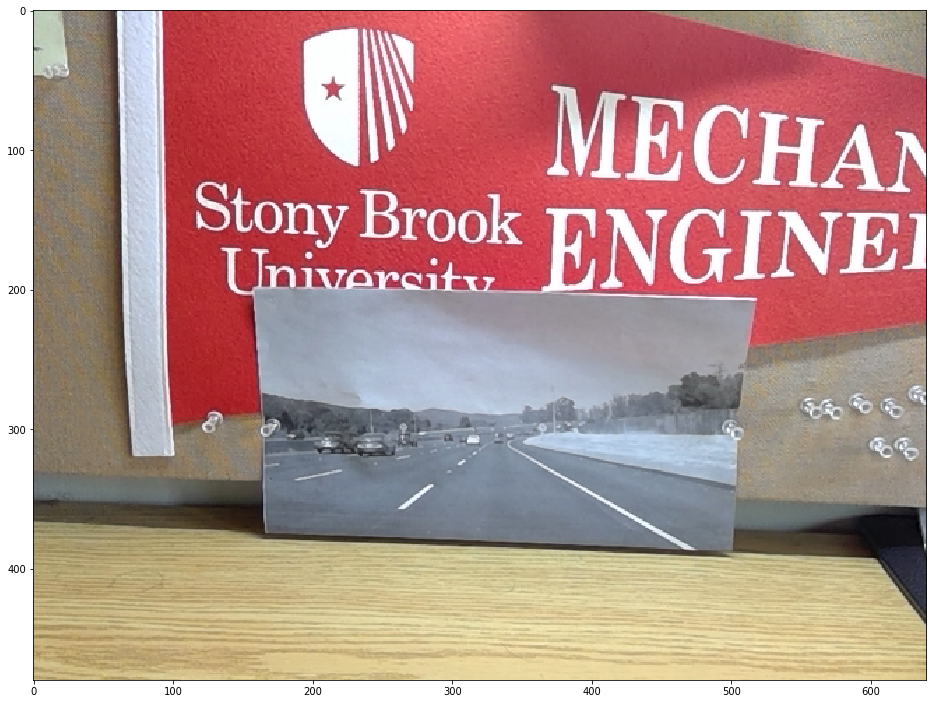

(480, 640, 3)


In [3]:
from ipywidgets import Widget
Widget.close_all()
test_env=cv2.cvtColor(cv2.imread('other_images/record.png', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

fig1 = plt.figure(figsize = (16,16))
ax1 = fig1.add_subplot(111)
ax1.imshow(test_env)
plt.show()
print(test_env.shape)

# Displaying Real-time Camera feed in `Jupyter notebook`

Many ideas were tried to display the live feed. Use of `pyplot`, `pylab`, `PIL`, and `cv2` for displaying the camera feed was not possible due to poor 2-3 fps performance. The performance using `IPython.display` module was much better. We were able to get 24-25fps on displaying the camera feed within the Jupyter notebook. However, the feed was flashing due to use of `clear_output()` function. Finally, use of `ipywigets` was explored. Even though the camera feed was displayed at 15-16fps, the display didn't flash. Thus, they were presented as a good comprimise and were used for the project.

In [4]:
# REFERENCE: https://github.com/NicksonYap/Jupyter-Webcam/blob/master/Realtime_video_ipython_py3.ipynb

# Import the required modules
import cv2
import numpy as np
from IPython.display import clear_output, display, Image
import PIL.Image
from io import BytesIO
import ipywidgets as widgets


#Use 'jpeg' instead of 'png' (~5 times faster)
#Ploting an Image Ipython object
def plot(IMG, ext='jpeg'): #OUTPUT FLASHES
    byteObj = BytesIO()
    PIL.Image.fromarray(IMG).save(byteObj, ext)
    display(Image(data=byteObj.getvalue()))

#%pylab inline 
def plot2(frame): #TOO SLOW 
    imshow(frame)
    show()
    
def plot3(frame): #TOO SLOW 
    plt.imshow(frame)
    display(plt.gcf())

#cv2.startWindowThread()
#cv2.namedWindow("Capture")
def plot4(frame): #No windows
    cv2.imshow("Capture", frame)
    cv2.waitKey(0)
    
#Using Ipython Image wiget
def img2ByteArr(frame, ext='jpeg'):
    byteObj = BytesIO()
    PIL.Image.fromarray(frame).save(byteObj, ext)
    return byteObj.getvalue()

In [5]:
cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 360)

#Create Ipython image widget
w=widgets.Image();
display(w)

for frame_number in range(100):
    #Capture frame
    _, frame = cam.read()
    
    #Perform operation
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    #Display frame
    w.value=img2ByteArr(frame)

cam.release()
clear_output()
#print(frame.shape)

#Performance-1000frames in 58s= 17fps

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Benchmarking the real-time Lane-Detection pipeline

In our benchmarks, we observe that the camera pipeline works at **24 fps** which is satisfactory performance. All benchmarks are done on my **Surface Pro 5** with an **Intel Core i5-7300U CPU** and **8GB RAM**.

In [7]:
def benchmark_livestream(n_frames):
    cam = cv2.VideoCapture(0)
    cam.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 360)

    #Create Ipython image widget
    w=widgets.Image();
    display(w)
    
    lane=[[],[]];
    for frame_number in range(n_frames):
        #Capture frame
        _, frame = cam.read()

        #Perform operation
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame, Detail, lane= pipeline(frame ,Hyperparam, lane)

        #Display frame
        w.value=img2ByteArr(frame)
        
    cam.release()
    clear_output()

In [8]:
import time
start_time = time.time()
n_frames=100;
benchmark_livestream(n_frames)
end_time=time.time();
t= end_time - start_time
print("--- %s seconds ---" % (t))
print("--- %s Average fps ---"% (n_frames/t))

--- 7.244354724884033 seconds ---
--- 13.803851936805978 Average fps ---


In [9]:
%timeit benchmark_livestream(n_frames)

6.44 s ± 207 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
print("--- %s Average fps ---"% (100/6.56))

--- 15.24390243902439 Average fps ---


# Calibrating Camera on Car

Finally, we are ready to run our pipeline on an actual vehicle. First, we need to position our camera on the car's dashboard and calibrate it. During this calibration phase, we find a region mask which works well with our algorithm.
I am using the built-in camera on my PC which is a **Surface Pro 5**. My car is a **2010 Honda CRV**.

In [11]:
def calibrate_mask(n_frames):
    cam = cv2.VideoCapture(0)
    cam.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 360)
    
    #Create Ipython image widget
    w=widgets.Image();
    display(w)

    for frame_number in range(n_frames):
        _, frame = cam.read()

        #Perform operation
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        Low_Lf=[.05*frame.shape[1],frame.shape[0]]
        Up_Lf=[.45*frame.shape[1],.6*frame.shape[0]]
        Up_Rt=[.55*frame.shape[1],.6*frame.shape[0]]
        Low_Rt=[.95*frame.shape[1],frame.shape[0]]
        poly=np.array([[Low_Lf,Up_Lf,Up_Rt,Low_Rt]], dtype=np.int32)
        masked=region_of_interest(frame, poly)
        frame=weighted_img(masked, frame, .2)

        #Display frame
        w.value=img2ByteArr(frame)
        
    cam.release()
    clear_output()
    
calibrate_mask(100)

# Real-World Test

It's showtime. Let's run our camera pipeline on an actual vehicle and see how it performs.

In [19]:
# This function processes the live stream and displays it in the notebook

def process_livestream(n_frames):
    cam = cv2.VideoCapture(0)
    cam.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 360)
    
    #Create Ipython image widget
    w=widgets.Image();
    display(w)
    
    lane=[[],[]];
    for frame_number in range(n_frames):
        #Capture frame
        _, frame = cam.read()

        #Perform operation
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame, Detail, lane= pipeline(frame ,Hyperparam, lane)

        #Display frame
        w.value=img2ByteArr(Detail)
        
    cam.release()
    clear_output()

process_livestream(500)

In [22]:
# This function also saves the output of the stream.

def process_livestream_and_record(n_frames):
    cam = cv2.VideoCapture(0)
    cam.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 360)
    frame_array = []
    Detail_array=[]
    
    #Create Ipython image widget
    w=widgets.Image();
    display(w)
    
    lane=[[],[]];
    for frame_number in range(n_frames):
        #Capture frame
        _, frame = cam.read()

        #Perform operation
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame, Detail, lane= pipeline(frame ,Hyperparam, lane)

        #Display frame
        w.value=img2ByteArr(frame)
        
        #Save Frame to create a video
        frame_array.append(frame)
        Detail_array.append(Detail)
        
    cam.release()
    clear_output()
    
    #Saving Lane-detection Visualization Video
    height , width , layers =  frame.shape
    fps=15
    pathOut='realtime_video/CRV_RealTime_video.mp4'
    video = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, (width,height))
    for i in range(len(frame_array)):
        video.write(cv2.cvtColor(frame_array[i], cv2.COLOR_RGB2BGR))
    video.release()

    #Saving Pipeline Visualization Video
    height , width , layers =  Detail.shape
    pathOut='realtime_video/CRV_RealTime_video_Detail.mp4'
    video = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, (width,height))
    for i in range(len(Detail_array)):
        video.write(cv2.cvtColor(Detail_array[i], cv2.COLOR_RGB2BGR))
    video.release()

process_livestream_and_record(450) #FOR 30s CLIPS